In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')

In [ ]:
# config
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 100 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = 'Cats'

train_data=datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

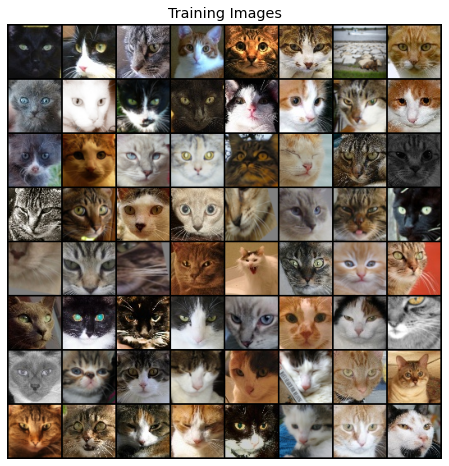

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (3) x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [ ]:
# loss function
criterion = nn.BCELoss()

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones((size,))
    return data.to(device)
    
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros((size,))
    return data.to(device)

In [ ]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake).view(-1)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [ ]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake).view(-1)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
reference_noise = torch.randn(64, nz, 1, 1).to(device)

In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz, 1, 1).to(device)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz, 1, 1).to(device))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    #saving a reference image
    results = generator(reference_noise).detach()
    results = make_grid(results)
    save_image(results, f"outputs/result_{epoch}.png")
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

59it [00:53,  1.11it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 0 of 200
Generator loss: 11.06457424, Discriminator loss: 0.73359978


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1 of 200
Generator loss: 4.74269009, Discriminator loss: 0.77050078


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2 of 200
Generator loss: 5.43305016, Discriminator loss: 0.65153873


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3 of 200
Generator loss: 6.74933195, Discriminator loss: 0.45884696


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4 of 200
Generator loss: 5.67968416, Discriminator loss: 0.75977886


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5 of 200
Generator loss: 4.43907642, Discriminator loss: 0.79280019


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6 of 200
Generator loss: 4.29052925, Discriminator loss: 0.71045572


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7 of 200
Generator loss: 4.35009289, Discriminator loss: 0.72205693


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8 of 200
Generator loss: 4.32854176, Discriminator loss: 0.71061885


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9 of 200
Generator loss: 4.60882807, Discriminator loss: 0.68338346


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10 of 200
Generator loss: 4.67415524, Discriminator loss: 0.73907936


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 11 of 200
Generator loss: 4.46814442, Discriminator loss: 0.70211846


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 12 of 200
Generator loss: 4.69486713, Discriminator loss: 0.81692261


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 13 of 200
Generator loss: 4.49326754, Discriminator loss: 0.80864167


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 14 of 200
Generator loss: 4.28217649, Discriminator loss: 0.73553669


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 15 of 200
Generator loss: 4.20263004, Discriminator loss: 0.80015349


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 16 of 200
Generator loss: 4.10717154, Discriminator loss: 0.74087077


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 17 of 200
Generator loss: 3.83414960, Discriminator loss: 0.74552739


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 18 of 200
Generator loss: 3.97934413, Discriminator loss: 0.75249982


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 19 of 200
Generator loss: 3.92267990, Discriminator loss: 0.67908752


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 20 of 200
Generator loss: 3.93087268, Discriminator loss: 0.78389698


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 21 of 200
Generator loss: 3.80552268, Discriminator loss: 0.68108582


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 22 of 200
Generator loss: 3.85310864, Discriminator loss: 0.68344498


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 23 of 200
Generator loss: 3.72831321, Discriminator loss: 0.76657820


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 24 of 200
Generator loss: 3.73929763, Discriminator loss: 0.60890687


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 25 of 200
Generator loss: 3.80006456, Discriminator loss: 0.69086486


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 26 of 200
Generator loss: 3.74153328, Discriminator loss: 0.62991732


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 27 of 200
Generator loss: 3.67471433, Discriminator loss: 0.71611410


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 28 of 200
Generator loss: 3.55257726, Discriminator loss: 0.62209314


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 29 of 200
Generator loss: 3.82093668, Discriminator loss: 0.81398916


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 30 of 200
Generator loss: 3.41036510, Discriminator loss: 0.54880500


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 31 of 200
Generator loss: 3.55953288, Discriminator loss: 0.64288968


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 32 of 200
Generator loss: 3.56149340, Discriminator loss: 0.74669451


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 33 of 200
Generator loss: 3.64982605, Discriminator loss: 0.64433819


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 34 of 200
Generator loss: 3.57549524, Discriminator loss: 0.70237172


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 35 of 200
Generator loss: 3.47970104, Discriminator loss: 0.67687947


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 36 of 200
Generator loss: 3.50032067, Discriminator loss: 0.86595851


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 37 of 200
Generator loss: 3.30076265, Discriminator loss: 0.58388454


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 38 of 200
Generator loss: 3.40213752, Discriminator loss: 0.79918480


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 39 of 200
Generator loss: 3.41538334, Discriminator loss: 0.68539804


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 40 of 200
Generator loss: 3.17541790, Discriminator loss: 0.61127716


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 41 of 200
Generator loss: 3.51631665, Discriminator loss: 0.79525369


59it [00:54,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 42 of 200
Generator loss: 3.32858467, Discriminator loss: 0.69590628


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 43 of 200
Generator loss: 3.17658019, Discriminator loss: 0.65640628


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 44 of 200
Generator loss: 3.24407101, Discriminator loss: 0.64409453


59it [00:54,  1.08it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 45 of 200
Generator loss: 3.28870821, Discriminator loss: 0.72784644


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 46 of 200
Generator loss: 3.22679877, Discriminator loss: 0.64735824


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 47 of 200
Generator loss: 3.32204723, Discriminator loss: 0.79278874


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 48 of 200
Generator loss: 3.24670434, Discriminator loss: 0.67002153


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 49 of 200
Generator loss: 3.27958202, Discriminator loss: 0.62802535


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 50 of 200
Generator loss: 3.24899578, Discriminator loss: 0.70957184


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 51 of 200
Generator loss: 3.31957364, Discriminator loss: 0.66775244


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 52 of 200
Generator loss: 3.32509828, Discriminator loss: 0.72406107


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 53 of 200
Generator loss: 3.18831372, Discriminator loss: 0.91181487


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 54 of 200
Generator loss: 3.07931709, Discriminator loss: 0.64285779


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 55 of 200
Generator loss: 3.05814552, Discriminator loss: 0.67057341


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 56 of 200
Generator loss: 3.15288067, Discriminator loss: 0.64287078


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 57 of 200
Generator loss: 3.13104677, Discriminator loss: 0.74845374


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 58 of 200
Generator loss: 3.27178741, Discriminator loss: 0.74113148


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 59 of 200
Generator loss: 3.05779386, Discriminator loss: 0.55382234


59it [00:55,  1.07it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 60 of 200
Generator loss: 3.16957450, Discriminator loss: 0.76740789


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 61 of 200
Generator loss: 3.08067822, Discriminator loss: 0.98362720


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 62 of 200
Generator loss: 3.05514073, Discriminator loss: 0.71023118


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 63 of 200
Generator loss: 3.13123655, Discriminator loss: 0.67180926


59it [00:55,  1.06it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 64 of 200
Generator loss: 3.29300284, Discriminator loss: 0.65739989


59it [00:56,  1.05it/s]
  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 65 of 200
Generator loss: 3.01327062, Discriminator loss: 0.52794451


 34%|███▍      | 20/58 [00:19<00:36,  1.05it/s]

KeyboardInterrupt: ignored

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


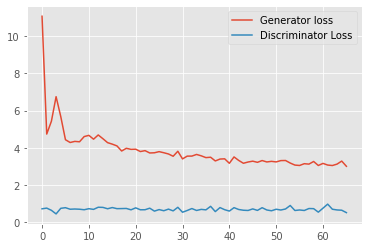

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

In [ ]:
for y in range(0, 1000):
  start_noise = torch.randn(1, nz, 1, 1).to(device)
  stop_noise = torch.randn(1, nz, 1, 1).to(device)
  tensors = []
  for x in range(0, 64):
    tensors.append((float(x)/64.0)*stop_noise+(1-(float(x)/64.0))*start_noise)
  b = torch.Tensor(64, nz, 1, 1).to(device)
  torch.cat(tensors, out=b)
  #saving a reference image
  results = generator(b).detach()
  results = make_grid(results)
  save_image(results, f"linspace/inter{y}.png")